![Diagram](diagram.png)

### 1. Import and variables setup

In [1]:
#Core imports
import os
import io
import html
import matplotlib.pyplot as plt
#Audio imports
from ipywebrtc import AudioRecorder, CameraStream
from IPython.display import Audio
#GCP - DataQnA imports
from google.api_core.client_options import ClientOptions
from google.cloud.dataqna import AutoSuggestionServiceClient, Question, QuestionServiceClient, SuggestQueriesRequest
from google.cloud import bigquery
#GCP - StT imports
from google.cloud import speech
#GCP - Translate API
from google.cloud import translate_v2 as translate

In [2]:
#Variables
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'key.json'
project = "velascoluis-test"
location = "us"
dataset="dataqna"
table="natality"
scope = f"//bigquery.googleapis.com/projects/{project}/datasets/{dataset}/tables/{table}"
RATE = 48000
lang_code="es-ES"

Tabla inspection: U.S.A. natality data

In [3]:
!gcloud alpha bq tables describe --dataset dataqna_eu natality

creationTime: '1610034903169'
etag: OdoZ2kXnqLC8kN5xUpBIMA==
id: velascoluis-test:dataqna_eu.natality
kind: bigquery#table
lastModifiedTime: '1610034903169'
location: EU
numBytes: '23562717384'
numLongTermBytes: '0'
numRows: '137826763'
schema:
  fields:
  - name: source_year
    type: INTEGER
  - name: year
    type: INTEGER
  - name: month
    type: INTEGER
  - name: day
    type: INTEGER
  - name: wday
    type: INTEGER
  - name: state
    type: STRING
  - name: is_male
    type: BOOLEAN
  - name: child_race
    type: INTEGER
  - name: weight_pounds
    type: FLOAT
  - name: plurality
    type: INTEGER
  - name: apgar_1min
    type: INTEGER
  - name: apgar_5min
    type: INTEGER
  - name: mother_residence_state
    type: STRING
  - name: mother_race
    type: INTEGER
  - name: mother_age
    type: INTEGER
  - name: gestation_weeks
    type: INTEGER
  - name: lmp
    type: STRING
  - name: mother_married
    type: BOOLEAN
  - name: mother_birth_state
    type: STRING
  - name: cigare

### 2. Record voice using local mic.

Example queries in Spanish:
* ¿Cómo se ven afectadas las semanas de gestación promedio por beber? - OK
* ¿Cuál es el mes más frecuente? - OK
* Obtener el peso récord máximo por cada raza - OK
* Compara  muertos y vivos para el estado AL

In [4]:
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [ ]:
We need to change the webm file to a compatib

In [5]:
with open("recording.webm", 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav command.wav -y -hide_banner -loglevel panic

### 3. Transcript audio file using Google Cloud Speech-to-Text

In [93]:
transcript = ""
client = speech.SpeechClient()
with io.open("command.wav", "rb") as audio_file:
    content = audio_file.read()
    audio = speech.RecognitionAudio(content=content)
    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=RATE,
        language_code=lang_code,
    )
    response = client.recognize(config=config, audio=audio)
    for result in response.results:
        transcript = result.alternatives[0].transcript
        print(f'''ES StT transcript command: {transcript} ''')

ES StT transcript command: compara muertos y vivos para el Estado a L 


### 4.Translate to English

In [94]:
translate_client = translate.Client()
result = translate_client.translate(transcript, target_language="en")
input_sql = html.unescape(result["translatedText"])
print(f'''EN Input command: {input_sql} ''')

EN Input command: compares dead and alive for the State to L 


### 5. Call DataQnA to execute SQL against BQ

In [95]:
client_options = ClientOptions(api_endpoint=f"{location}-dataqna.googleapis.com")
suggest_client = AutoSuggestionServiceClient(client_options=client_options)
questions_client = QuestionServiceClient(client_options=client_options)
bq_client = bigquery.Client()
parent = questions_client.common_location_path(project, location)
question = Question(scopes=[scope], query=input_sql)
question_response = questions_client.create_question(parent=parent, question=question)
chosen_interpretation_index = 0
question_response = questions_client.execute_question(name=question_response.name, interpretation_index=chosen_interpretation_index)
chosen_interpretation = question_response.interpretations[chosen_interpretation_index]
bigquery_job = chosen_interpretation.execution_info.bigquery_job
job = bq_client.get_job(bigquery_job.job_id, bigquery_job.project_id, bigquery_job.location)
job_results = job.result()
headers = [schema_field.name for schema_field in job_results.schema]
results = [dict(row) for row in job_results]
print(f'''Question: {question_response.query}
Interpretation: {chosen_interpretation.human_readable.generated_interpretation.text_formatted}
SQL Query:
{chosen_interpretation.data_query.sql}
Results:
{results}
''')

Question: compares dead and alive for the State to L
Interpretation: Compare born_dead, born_alive_alive by state
SQL Query:
SELECT
  state AS state,
  (SUM(born_dead)) AS SUM_born_dead,
  (SUM(born_alive_alive)) AS SUM_born_alive_alive
FROM
  `velascoluis-test.dataqna.natality`
GROUP BY state;
Results:
[{'state': 'ID', 'SUM_born_dead': 222904, 'SUM_born_alive_alive': 732386}, {'state': 'AK', 'SUM_born_dead': 190427, 'SUM_born_alive_alive': 390708}, {'state': 'ND', 'SUM_born_dead': 139871, 'SUM_born_alive_alive': 361923}, {'state': 'MT', 'SUM_born_dead': 303186, 'SUM_born_alive_alive': 514305}, {'state': 'NH', 'SUM_born_dead': 481179, 'SUM_born_alive_alive': 600422}, {'state': 'VT', 'SUM_born_dead': 226876, 'SUM_born_alive_alive': 285829}, {'state': 'DC', 'SUM_born_dead': 319666, 'SUM_born_alive_alive': 577146}, {'state': 'SD', 'SUM_born_dead': 185170, 'SUM_born_alive_alive': 455305}, {'state': 'AL', 'SUM_born_dead': 545784, 'SUM_born_alive_alive': 1957848}, {'state': 'AR', 'SUM_born_d

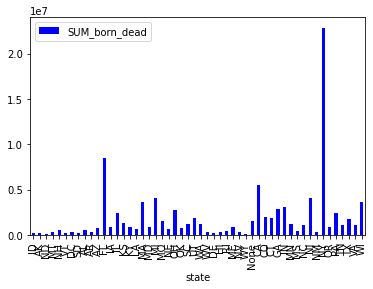

In [96]:
df = job.result().to_dataframe()
df.plot(kind='bar',x=df.columns[0],y=df.columns[1],color='blue')
plt.show()